In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('health_data.csv')
data.head()

,age,restbps,chol,category
0,26,109,243,0
1,27,106,156,0
2,28,107,225,0
3,27,105,277,0
4,30,96,221,0


In [3]:
#first, lets try a bayes classifier with the class conditional densities assumed to be Gaussian. There are two categories, 0 and 1.
X = data.to_numpy()[:, :3]
Y = data.to_numpy()[:, 3]


split = 0.8 #using 70:30 split, random each time
train_samples = np.random.choice(X.shape[0], int(split*X.shape[0]))
test_samples = np.array([i for i in range(X.shape[0]) if i not in list(train_samples)])

X_train = X[[train_samples]]
Y_train = Y[[train_samples]]

X_test = X[[test_samples]]
Y_test = Y[[test_samples]]


X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]

#X_0 = data[data['category'] == 0].to_numpy()[:, :3]
#X_1 = data[data['category'] == 1].to_numpy()[:, :3]
#how to split data into test and train?


C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the f

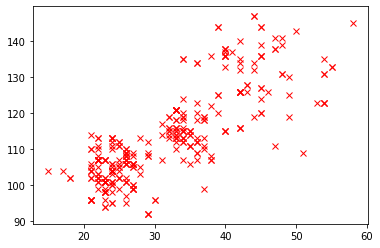

In [4]:
plt.plot(X_0[:,0], X_0[:,1], 'rx') #cholestrol vs age
#clearly they are not independent features

In [5]:
#estimating mean, variance for class 0
#maximum likelihood estimate

u0 = np.mean(X_0, axis=0) 
s0 = (X_0 - u0).T @ (X_0 - u0)/X_0.shape[0]
s0 = np.linalg.inv(s0)

#for class 1
u1 = np.mean(X_1, axis = 0)
s1 = (X_1 - u1).T @ (X_1 - u1)/X_1.shape[0]
s1 = np.linalg.inv(s1) #inverse of cov matrix

In [6]:
#decision boundary
p0 = X_0.shape[0]; p1 = X_1.shape[0]
p0 = p0/(p0 + p1); p1 = 1 - p0;
print('p0 = {}, p1 = {}'.format(p0, p1))
#priors chosen on basis of frequency of occurence in training data.
p = np.log(p0/p1)

s = 0.5*np.log(np.linalg.det(s0)/np.linalg.det(s1))
def g1(x):
    y = p + s -0.5*((x - u0) @ s0 @ (x-u0).T - (x - u1) @ s1 @ (x - u1))
    
    if (y > 0): 
        return 0
    else:return 1

p0 = 0.55, p1 = 0.44999999999999996


In [7]:
#computing accuracy.
C = np.zeros((2,2)) #[[]]
for i in range((X_test.shape[0])):
    y_pred = g1(X_test[i])
    C[y_pred, Y_test[i]] += 1
        

In [8]:
acc = (C[0,0] + C[1,1])/np.sum(C)
print(acc)
# nearly 85 % accuracy obtained, in almost every case, no matter how the data is split.

0.8411214953271028


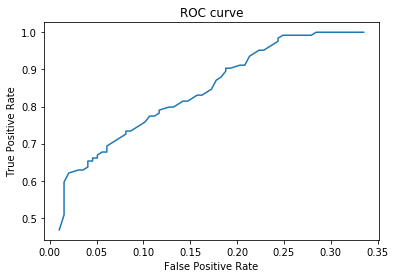

In [9]:
#Now, we will vary the priors, and plot the ROC curve.
TP = []
FP = []
for p0 in np.linspace(0.01,0.99,100):
    p = np.log(p0/(1 - p0))
    def g2(x):
        y = p + s -0.5*((x - u0) @ s0 @ (x-u0).T - (x - u1) @ s1 @ (x - u1))
    
        if (y > 0): 
            return 0
        else:return 1
    C = np.zeros((2,2))
    for i in range((X_test.shape[0])):
        y_pred = g2(X_test[i])
        C[y_pred, Y_test[i]] += 1
    
    tpr = C[1,1]/(C[1,1] + C[0,1])
    fpr = C[1,0]/(C[1,0] + C[0,0])
    TP.append(tpr)
    FP.append(fpr)

plt.plot(FP, TP, '-')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

# Gaussian mixture model
#kaafi complex.
#we have set of parameters, u_k, s_k, and pi_k.
'''
import math

def Gauss(x, u, s):
    d = x.shape[0]
    
    a = np.exp(-0.5*(x-u) @ np.linalg.inv(s) @ (x-u).T)
    S = np.abs(np.linalg.det(s))**(-0.5)
    
    return ((2*math.pi)**(-d/2))*S*a

#setting the number of components
K = 2
D = X.shape[1]
U = np.random.rand(K, D) #means

#guess for U
U = np.array([[35,110, 200],[60, 140, 250]])
S = np.random.rand(K, D, D)*50 #variances

print(U)
print(S)
P = np.random.rand(K); P = np.exp(P); P = P/sum(P); #pi's
N = X_train.shape[0]
G = np.zeros((N,K))

print(P)
def gamma(n, k):
    sum = 0;
    for j in range(K):
        sum += P[j]*Gauss(X_train[n], U[j, :], S[j, :, :]);
        #print('sum = ', sum);
    return P[k]*Gauss(X_train[n], U[k, :], S[k, :, :])/sum;

l_old = -1
thresh = 1e-3
iterations = 0


while(True):
    #E_step
    print('iter = {}, l = {}'.format(iterations, l_old))
    for i in range(N):
        for j in range(K):
            G[i, j] = gamma(i, j)
    
    #M step
    N_k = np.sum(G, axis = 0)
    #print('G.T:{}, X:{}, N_k:{}'.format(G.T.shape, X_train.shape, N_k.shape))
    U = (G.T @ X_train)/(N_k[:, np.newaxis])
    for k in range(K): #improve by using broadcasting!
        #print((X_train - U[k,:]).shape)
        #print(G[:, k].shape)
        S[k, :] = ((X_train - U[k, :]).T @ (G[:,k][:,np.newaxis]*(X_train - U[k, :])))/N_k[k]
    P = N_k/N
    
    #computing likelihood
    l = 0
    for i in range(N):
        s = 0
        for j in range(K):
            s += P[j]*Gauss(X_train[i], U[j, :], S[j, :, :])
            #print(s)
        l += np.log(s)
    #input()
    if np.abs(l - l_old) < thresh and iterations != 0:
        break;
    iterations += 1
    l_old = l
print('Done.')
#EM complete!!
'''

In [10]:
import math

def Gauss(x, u, s):
    d = x.shape[0]

    a = np.exp(-0.5*(x-u) @ np.linalg.inv(s) @ (x-u).T)
    S = np.abs(np.linalg.det(s))**(-0.5)

    return ((2*math.pi)**(-d/2))*S*a

def GMM(X, K):
    #Gaussian mixture model
    #X:data, K:number of components

    
    D = X.shape[1] #dimenionality of the data
    N = X.shape[0] #no of samples
    U = X[np.random.choice(N, K)] #initializing means as some K points in the data
    
    cov = np.cov(X, rowvar=False)
    
    #S = np.random.rand(K, D, D)*50 #variances
    S = np.stack([cov for k in range(K)], axis=0) #setting cov matrix of the data as guess for S
    
    #P = np.random.rand(K); P = np.exp(P); P = P/sum(P); #pi's, the contribution of each component
    P = np.ones(K)/K
    G = np.zeros((N,K))

    def gamma(n, k):
        sum = 0;
        for j in range(K):
            sum += P[j]*Gauss(X[n], U[j, :], S[j, :, :]);
            #print('sum = ', sum);
        return P[k]*Gauss(X[n], U[k, :], S[k, :, :])/sum;

    l_old = -1
    thresh = 1e-3
    iterations = 0
    loss_hist = []

    while(True):
        #E_step
        #print('iter = {}, l = {}'.format(iterations, l_old))
        for i in range(N):
            for j in range(K):
                G[i, j] = gamma(i, j)

        #M step
        N_k = np.sum(G, axis = 0)
        #print('G.T:{}, X:{}, N_k:{}'.format(G.T.shape, X_train.shape, N_k.shape))
        U = (G.T @ X)/(N_k[:, np.newaxis])
        for k in range(K): #improve by using broadcasting!
            #print((X_train - U[k,:]).shape)
            #print(G[:, k].shape)
            S[k, :] = ((X - U[k, :]).T @ (G[:,k][:,np.newaxis]*(X - U[k, :])))/N_k[k]
        P = N_k/N

        #computing likelihood
        l = 0
        for i in range(N):
            s = 0
            for j in range(K):
                s += P[j]*Gauss(X[i], U[j, :], S[j, :, :])
                #print(s)
            l += np.log(s)
        #input()
        loss_hist.append(l)
        if np.abs(l - l_old) < thresh and iterations != 0:
            break;
        iterations += 1
        l_old = l
    print('Done.')
    return P, U, S, loss_hist

#function to evaluate p(x) given parameters of GMM
def calc_p_gmm(x, a):
    #x: input point, a:parameters, returned from function GMM
    P = a[0]
    U = a[1]
    S = a[2]
    K = P.shape[0]
    sum = 0
    for k in range(K):
        sum += P[k]*Gauss(x, U[k, :], S[k, :, :])
    return sum

Done.
Done.


Text(0.5, 1.0, 'EM for class 0')

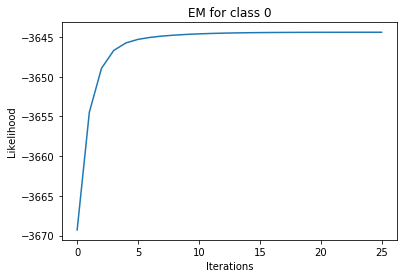

In [11]:
a0 = GMM(X_0, 2)
a1 = GMM(X_1, 2)
plt.plot(a0[3]);
plt.xlabel('Iterations'); plt.ylabel('Likelihood');
plt.title('EM for class 0')

Text(0.5, 1.0, 'EM for class 1')

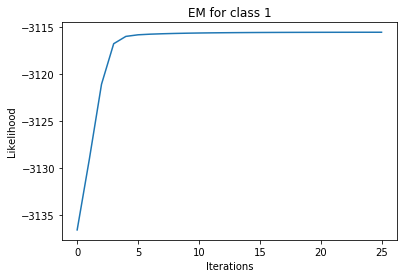

In [12]:
plt.plot(a1[3])
plt.xlabel('Iterations'); plt.ylabel('Likelihood');
plt.title('EM for class 1')

In [13]:
#building the bayes classifier for this GMM.
#how to choose priors?

def g3(x, a0, a1, p0):
    #a0, a1: parameters from EM for GMM. p0: prior probabilities
    if(p0*calc_p_gmm(x, a0) > (1-p0)*calc_p_gmm(x, a1)):
        return 0
    else:
        return 1

#calculating accuracy on the test set.
C = np.zeros((2,2)) #[[]]
for i in range((X_test.shape[0])):
    y_pred = g3(X_test[i], a0, a1, 0.5)
    C[y_pred, Y_test[i]] += 1
acc = (C[0,0] + C[1,1])/np.sum(C)
print(acc)

#84 percent accuracy acheived. Almost Same as previous case. Maybe varying priors will give better results.

#How to visualize these GMMs ??

0.8317757009345794


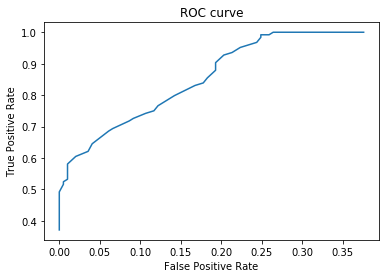

In [14]:
#plotting ROC curve.
TP = []
FP = []
for p0 in np.linspace(0.01,0.99,50):

    C = np.zeros((2,2))
    for i in range((X_test.shape[0])):
        y_pred = g3(X_test[i], a0, a1, p0)
        C[y_pred, Y_test[i]] += 1
    
    tpr = C[1,1]/(C[1,1] + C[0,1])
    fpr = C[1,0]/(C[1,0] + C[0,0])
    TP.append(tpr)
    FP.append(fpr)

plt.plot(FP, TP, '-')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


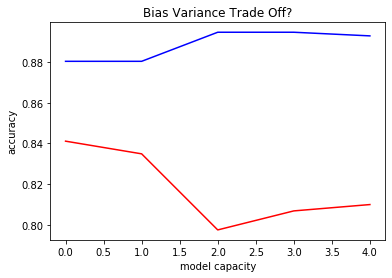

In [28]:
#visualizing bias-variance trade off? Increasing model capacity(k) and then getting training and testing accuracies.
train_accuracies = []
train_loss = []

test_accuracies = []
test_loss = []

#lets define... 0-1 loss
def loss(y, y_):
    return np.abs(y - y_)

for k in range(2, 7):
    a0 = GMM(X_0, k)
    a1 = GMM(X_1, k)
    
    C = np.zeros((2,2)) #[[]]
    l = 0
    for i in range((X_test.shape[0])):
        y_pred = g3(X_test[i], a0, a1, 0.5)
        l += loss(y_pred, Y_test[i])
        C[y_pred, Y_test[i]] += 1
    acc = (C[0,0] + C[1,1])/np.sum(C)
    test_accuracies.append(acc)
    test_loss.append(l)
    
    
    C = np.zeros((2,2)) #[[]]
    l = 0
    for i in range((X_train.shape[0])):
        y_pred = g3(X_train[i], a0, a1, 0.5)
        l += loss(y_pred, Y_train[i])
        C[y_pred, Y_train[i]] += 1
    acc = (C[0,0] + C[1,1])/np.sum(C)
    train_accuracies.append(acc)
    train_loss.append(l)

plt.plot(train_accuracies, 'b-');
plt.plot(test_accuracies, 'r-');
plt.xlabel('model capacity');
plt.ylabel('accuracy');
plt.title('Bias Variance Trade Off?');
    

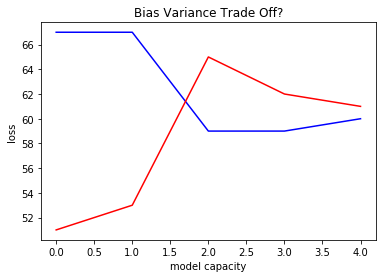

In [29]:
plt.plot(train_loss, 'b-');
plt.plot(test_loss, 'r-');
plt.xlabel('model capacity');
plt.ylabel('loss');
plt.title('Bias Variance Trade Off?');

In [24]:
print(test_accuracies)
print(train_accuracies)

[0.8411214953271028, 0.822429906542056, 0.8193146417445483, 0.7975077881619937, 0.7975077881619937]
[0.8803571428571428, 0.8982142857142857, 0.8875, 0.9, 0.8928571428571429]


# MAP Estimation
with guassian prior

In [15]:
def MAP(X, mu_0, sigma_0):
    #mu = np.zeros(X.shape[1])
    sigma = np.cov(X, row_var = False); #guess for cov matrix of X.

    #prior_distribution
    N = X.shape[0]

    mu_n_ = np.sum(X, axis=0)
    mu_n = sigma_0 @ np.linalg.inv(sigma_0 + sigma/N) @ mu_n_[:, np.newaxis] + sigma @ np.linalg.inv(sigma_0 + (sigma)/n) @ mu_0[:, np.newaxis]
    sigma_n = sigma_0 @ np.linalg.inv(sigma_0 + sigma/n) @ sigma/n
    
    return mu_n, sigma_n
    #p(x | D) ~ N(mu_n, sigma + sigma_n).
    #p(mu | D) ~ N(mu_n, sigma_n).

#How to decide bias!!??

# Using PCA to visualize the input data

PCA( _Principal Component Analysis_ ) is a technique that can be used to reduce the dimensions of the dataset. Here I will use it so that I can reduce the dimension of the input data(3) to 2 so that I can easily plot it on a 2-D graph for better visualization.

In [16]:
#data visualization with PCA, so that i can reduce the number of dimensions to 2 and plot them easily.
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_ = pca.fit_transform(X);


In [17]:
X_.shape

(700, 2)

Text(0.5, 1.0, 'Principal Compenent Analysis')

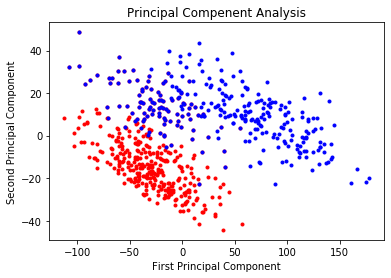

In [18]:
X__0 = X_[Y==0]
X__1 = X_[Y==1]

plt.plot(X__0[:,0],X__0[:,1], 'r.');
plt.plot(X__1[:,0],X__1[:,1], 'b.');
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("Principal Compenent Analysis")

In [19]:
a = np.linalg.eigh(np.cov(X, rowvar = False))
print(a)
#PCA seems to be a good method.

(array([  40.23041129,  317.09909608, 3229.19618034]), array([[ 0.84214145,  0.50926223,  0.17734078],
       [-0.53666212,  0.82369458,  0.18308746],
       [-0.05283512, -0.24935762,  0.96696909]]))


Done.


[]

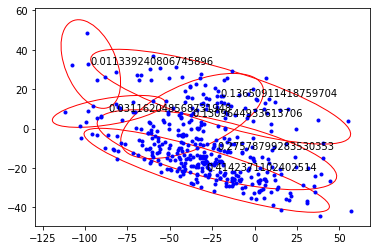

In [20]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
a_ = GMM(X__0, 6)
U = a_[1]
P = a_[0]
S = a_[2]
def confidence_ellipse(cov, u, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    



    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = u[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = u[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
fig, ax = plt.subplots()
ax.plot(X__0[:,0], X__0[:, 1], 'b.')

for k in range(U.shape[0]):
    ax.text(U[k][0], U[k][1], "{}".format(P[k]))
    confidence_ellipse(S[k], U[k], ax, n_std=2.5, edgecolor='red')
plt.plot()